# Import Libraries
All vanilla code and functions demonstrated below are completely orignal. 

System was designed by Gabriel Giangi, Tomas Pereira and Aryamann Mehra from Concordia University in Montreal, Canada.

In [23]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier # Model used for carrier recommendation system
from sklearn.model_selection import train_test_split # Used to split our dataset into training and test sets
from sklearn.ensemble import RandomForestRegressor # Model used for lane price prediction system
import warnings
warnings.filterwarnings('ignore') # Ignore warnings for cleaner display (remove this for debugging)

# 1. Carrier Reccomendation System 
In this section, we construct a Random Forest Classifier using the sklearn library and modules. Although ideally the problem at hand is a multi-label classification problem, our data is formatted in a way that only supports multi-class classification. As you will see in the later steps, we transform our problem into a multi-label classifcation by making the classifier multi-output with the best N probabilities.

## 1.1 Import Data
The data is formatted inside .CSV files, of which we used the pandas library to parse and save the data into corresponding dataframes. We then normalize the data by ensuring continous data types are formatted as continous, and one-hot-encode the categorical features. The last step involves using sklearn to split our data into proper training and test sets.

The training set is split relatively higher than the standard, due to the imbalances of label occurences in our dataset. There are some labels that only appear once, so to ensure the model "sees" as many of these labels as possible during training, we allocated 90% of the data towards training.

In [24]:
# Import and store data
X = pd.read_csv('X.csv', header=0)
y = pd.read_csv('y.csv', header=0)

# Normalize Dataset
X = X.astype({"Quantity": 'float64', 'Ship Date': 'float64'})

X_enc = sklearn.preprocessing.OneHotEncoder()
X_object = X.select_dtypes('object')
X_enc.fit(X_object)
codes = X_enc.transform(X_object).toarray()

X = pd.concat([X.select_dtypes(exclude='object'), 
               pd.DataFrame(codes).astype(int)], axis=1)

yle = sklearn.preprocessing.LabelEncoder()
yl = yle.fit_transform(y.values.ravel())

# Split data into training and test sets
X_train, X_test2, y_train, y_test2 = train_test_split(X, yl, random_state=22, train_size=.9)

## 1.2 Hyperparameter Selection
Firstly, we run k-fold configuration to determine the approximate 'best' fold split when we run random search in the preceding step. 

### 1.2.1 K-Fold Validation

From our findings, we found that the split when k is equal to 6 or 7, yielded the highest held-out validation accuracy (30.2%), so we will use this fold for our random search.

In [25]:
# K-Fold Validation
dt = RandomForestClassifier(random_state=22, n_jobs=-1)
dt.fit(X_train, y_train)

# Print vanilla model accuracies for context
print("{:.2f}".format((dt.score(X_train, y_train))*100), '% training accuracy')
print("{:.2f}".format((dt.score(X_test2, y_test2))*100), '% testing accuracy')

# Run k-fold validation
for k in range(2, 10):
    scores = sklearn.model_selection.cross_val_score(dt, X_train, y_train, cv=k)
    print("held-out accuracy (%d-fold):   %.1f%%" % (k, scores.mean()*100))

95.71 % training accuracy
28.66 % testing accuracy
held-out accuracy (2-fold):   29.3%
held-out accuracy (3-fold):   29.7%
held-out accuracy (4-fold):   29.8%
held-out accuracy (5-fold):   30.2%
held-out accuracy (6-fold):   30.2%
held-out accuracy (7-fold):   30.2%
held-out accuracy (8-fold):   29.7%
held-out accuracy (9-fold):   29.7%


### 1.2.2 Random Search Best Hyperparameter Configuration

From the random search, the best approximate hyperparameter configuration was as followed:

n_estimators = 250, 
max_depth = 15 with
validation set accuracy at 32.7%

In [28]:
# Random Search Best Hyperparameter Configuration (with cv = 6)
dt = RandomForestClassifier(random_state=22, n_jobs=-1)

# Create hyperparameter dictionary to random search
estimators_grid = np.array([10, 50, 100, 150, 200, 250, 300])
depth_grid = np.array([1, 2, 5, 10, 14, 15, 16, 18, 20, 25, 50, 100, None])

param_grid = {'max_depth': depth_grid, 'n_estimators': estimators_grid}
randcv = sklearn.model_selection.RandomizedSearchCV(dt, param_grid, n_iter=30, cv=6).fit(X_train, y_train.ravel())

# Print the best hyperparameter configuration found from search and the validation set accuracy
print('best parameters:', randcv.best_params_)
print('%.1f%% accuracy on validation sets (average)' % (randcv.best_score_*100))

best parameters: {'n_estimators': 250, 'max_depth': 15}
32.7% accuracy on validation sets (average)


## 1.3 Construct & Train Random Forest Model
Here we simply build our classification model with the well performing hyperparameters and print the test and training accuracy for intuition.

We got a training accuracy of 85.47% and test accuracy of 30.43%

In [29]:
# Create Random Forest Model
dt = RandomForestClassifier(random_state=22, n_estimators=250, max_depth=15, n_jobs=-1)
dt.fit(X_train, y_train)

# Train the model and print accuracies
train_accuracy = dt.score(X_train, y_train)
test_accuracy = dt.score(X_test2, y_test2)
print("%.2f%% training accuracy" % (train_accuracy*100))
print("%.2f%% testing accuracy" % (test_accuracy*100))

85.47% training accuracy
30.43% testing accuracy


# 2. Price Prediction System
This model aims to predict route carrier costs, based on weight, truck type, origin, destination, and more features. In conjuction with the carrier recommendation system, the two predicted metrics can give great insight into carrier shortages/surpluses in real time zones.

## 2.1 Import Data
The data is formatted inside .CSV files, of which we used the pandas library to parse and save the data into corresponding dataframes. We then normalize the data by ensuring continous data types are formatted as continous, and one-hot-encoding the categorical features. The last step involves using sklearn to split our data into proper training and test sets. The process is exactly the same as in 1.1, but with an additional feature: CARRIER.

In [30]:
# Import and store data
X = pd.read_csv('X2.csv', header=0)
y = pd.read_csv('y2.csv', header=0)

# Normalize Data
X = X.astype({"Quantity": 'float64', 'Ship Date': 'float64'})

X_enc2 = sklearn.preprocessing.OneHotEncoder()
X_object = X.select_dtypes('object')
X_enc2.fit(X_object)
codes = X_enc2.transform(X_object).toarray()

X = pd.concat([X.select_dtypes(exclude='object'), 
               pd.DataFrame(codes).astype(int)], axis=1)

yle = sklearn.preprocessing.LabelEncoder()
yl = yle.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, yl, random_state=22,train_size=.9)

## 2.2 Hyperparameter Selection
Firstly, we run k-fold configuration to determine the approximate 'best' fold split when we run random search in the preceding step. 

### 2.2.1 K-Fold Validation
From our findings, we found that the split when k=11 yielded the highest held-out accuracy, so we will use this fold for our random search.

In [31]:
# K-Fold Validation
regr = RandomForestRegressor(random_state=22, n_jobs = -1)
regr.fit(X_train, y_train.ravel())

# Print vanilla model accuracies for context
print("{:.2f}".format((regr.score(X_train, y_train))*100), '% training accuracy')
print("{:.2f}".format((regr.score(X_test, y_test))*100), '% testing accuracy')

# Run k-fold validation
for k in range(2, 13):
    scores = sklearn.model_selection.cross_val_score(regr, X_train, y_train.ravel(), cv=k)
    print("held-out accuracy (%d-fold):   %.2f%%" % (k, scores.mean()*100))

96.98 % training accuracy
77.07 % testing accuracy
held-out accuracy (2-fold):   76.80%
held-out accuracy (3-fold):   77.50%
held-out accuracy (4-fold):   77.91%
held-out accuracy (5-fold):   78.50%
held-out accuracy (6-fold):   78.69%
held-out accuracy (7-fold):   78.84%
held-out accuracy (8-fold):   79.00%
held-out accuracy (9-fold):   79.24%
held-out accuracy (10-fold):   79.40%
held-out accuracy (11-fold):   79.43%
held-out accuracy (12-fold):   79.34%


### 2.2.2 Random Search Best Hyperparameter Configuration
From the random search, the best approximate hyperparameter configuration was as followed:

n_estimators = 500, 
max_depth = 45 with
validation set accuracy at 79.5%

In [33]:
# Random Search Best Hyperparameter Configuration (with cv = 11)
regr = RandomForestRegressor(random_state=22, n_jobs=-1)

# Create hyperparameter dictionary to randomly search
estimators_grid = np.array([10, 50, 100, 150, 200,250,300,500])
depth_grid = np.array([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200, None])
param_grid = {'max_depth': depth_grid, 'n_estimators': estimators_grid}

# Run random search algorithm
randcv = sklearn.model_selection.RandomizedSearchCV(regr, param_grid, n_iter=30, cv=11)
randcv.fit(X_train, y_train.ravel())

# Print the best found hyperparameter configuration and validation accuracy
print('best parameters:', randcv.best_params_)
print('%.1f%% accuracy on validation sets (average)' % (randcv.best_score_*100))

best parameters: {'n_estimators': 500, 'max_depth': 45}
79.5% accuracy on validation sets (average)


## 2.3 Construct and Train Random Forest Regressor Model
Here we simply build our regression model with well performing hyperparameters and print the test and training accuracy for intuition. We obtained a testing accuracy of 77.5% and a training accuracy of 97.0%

In [34]:
regr = RandomForestRegressor(n_estimators=500, max_depth=45, random_state=22,
                             n_jobs=-1).fit(X_train, y_train)

train_accuracy = regr.score(X_train, y_train)
test_accuracy = regr.score(X_test, y_test)

print("%.1f%% training accuracy" % (train_accuracy*100))
print("%.1f%% testing accuracy" % (test_accuracy*100))

97.0% training accuracy
77.5% testing accuracy


# 3. Final System - Carrier Recommendation System 
Here in this final section, we combine both the classifier and the regression models with custom functions to display the best N carriers for a given route, and the predicted price per carrier. 

### 3.1 Import Data

In [35]:
# Import and store data
X = pd.read_csv('X.csv', header=0)
y = pd.read_csv('y.csv', header=0)

# Normalize Data
X = X.astype({"Quantity": 'float64', 'Ship Date': 'float64'})

X_enc = sklearn.preprocessing.OneHotEncoder()
X_object = X.select_dtypes('object')
X_enc.fit(X_object)
codes = X_enc.transform(X_object).toarray()

X = pd.concat([X.select_dtypes(exclude='object'), 
               pd.DataFrame(codes).astype(int)], axis=1)

yle = sklearn.preprocessing.LabelEncoder()
yl = yle.fit_transform(y)

X_train, X_test2, y_train, y_test2 = train_test_split(X, yl, random_state=22,
                                                      train_size=.9)

# 3.2 *CARRIER RECCOMENDATION SYSTEM* 
Here is the most important section of the notebook, as this is where we combine both models. In addition, we create three new custom functions *wrapInput*, *predictCarrier* and *predictPrice*. The role of these functions is to work together to accept custom lane input data, and make both a carrier recommendation with their predicted price. Please look at the docstrings to understand further how these functions work.

In [37]:
def wrapInput(inp):
    """ 
PARAMS:
The function takes in the custom input lane features as an array type (1 dimensional). This includes the features we feed to our model
in order to make a prediction. We assume these are in a particular order, which is:
[Date,Shipper City, Shipper State,Shipper Country, Consignee City, Consignee State, Consignee Country, Quantity, Type, Weight,
Equipment Type]

FUNCTIONALITY:
This function calls our helper functions and makes a prediction on the sample input 'inp'. It first gets the 5 best 
recommended carriers for the given route (and the corresponding probabilities), and then gets a price prediction for each
of these carriers. It displays the Top 5 carriers along with the individual price prediction for each carrier.

RETURNS:
0, because the function prints all the predictions and doesn't return this data to any other function.

"""
    # Call custom function PREDICTCARRIER 
    carrier, cp = predictCarrier(inp[0], inp[2], inp[3], inp[5], inp[6], inp[7],
                                 inp[8], inp[9], inp[10])
    # Iterate through the top 5 recommended carriers and call PREDICTPRICE custom function
    prices = []
    c = 0
    print('TOP 5 Carriers Recommended: ')
    for i in carrier:
        price = predictPrice(inp[0], inp[1], inp[2], inp[3], inp[4], inp[5],
                            inp[6], inp[7], inp[8], inp[9], inp[10], i)
        prices.append(price)
        print(carrier[c]+' - '+str(cp[c])+'%'+' - '+'$'+str(prices[c][0]))
        c += 1
    return 0


def predictCarrier(date, sstate, scountry, cstate, ccountry, qty, typ, weight, etype):
    """ 
PARAMS:
The function takes in the input features needed for making a carrier prediction. 
The function is mainly called by the wrapper function makeCustomPrediction the input features are split up into
different parameters, namely:
Date (string/int), Shipper State (string), Shipper Country (string), Consignee State (string), Consignee Country (string), 
Quantity (int), Type (string), Weight (int),
Equipment Type (string)

FUNCTIONALITY:
This function encodes our parameters with the encoders used for our ML models (one-hot for categorical, StandardScaler for continuous). 
It then gets a prediction(with probabilities) from our model for the custom input.
Further, it decodes the top 5 results based on our y-encoders. It also prints out the carrier with the highest probability.

RETURNS:
A 2-tuple of 1d arrays. The first array contains strings which are the names of the top 5 carriers. The second array returns
the corresponding probabilities of the top 5 carriers.

"""
    # Ensure features are normalized to proper dtype (continous vs discrete)
    date = float(date)
    weight = float(weight)
    qty = float(qty)
    cat_inp = [[sstate, scountry, cstate, ccountry, typ, etype]]
    num_inp = [[qty, weight, date]]
    
    codes = X_enc.transform(cat_inp).toarray()
    cenc = X_enc.transform(cat_inp).toarray()
    
    find = pd.concat([pd.DataFrame(num_inp), 
               pd.DataFrame(codes).astype(int)], axis=1)
    
    # Make prediction on lane features and transform for legible output
    pred = dt.predict_proba(find)
    # print(pred)
    n = 5  # N best probabilities

    top_n_lables_idx = np.argsort(-pred, axis=1)[:, :n]
    top_n_probs = np.round(-np.sort(-pred), 3)[:, :n]*100
    top_n_labels = [dt.classes_[i] for i in top_n_lables_idx]

    results = list(zip(top_n_labels, top_n_probs))
    top5_str = yle.inverse_transform(results[0][0])
    top5_probs = np.round(results[0][1], 1)
    top_str = yle.inverse_transform([results[0][0][0]])[0]

    print('\nTop Carrier: '+top_str+'\n')
    return top5_str, top5_probs


def predictPrice(date, scity, sstate, scountry, ccity, cstate, ccountry, qty, typ, weight, etype, carrier):
    """ 
PARAMS:
The function takes in the input features needed for making a price prediction. 
The function is mainly called by the wrapper function makeCustomPrediction the input features are split up into
different parameters, namely:
Date (string/int), Shipper City (string), Shipper State (string), Shipper Country (string), Consignee City (string), 
Consignee State (string), Consignee Country (string), Quantity (int), Type (string), Weight (int), 
Equipment Type (string), Carrier (string)

FUNCTIONALITY:
This function encodes our parameters with the encoders used for our ML models (one-hot for categorical, 
StandardScaler for continuous). It then gets a price prediction from our Regression model for the given route and given carrier.


RETURNS:
The predicted price for a trip based on the given route and given carrier.

"""
    # Ensure features are normalized to proper dtypes (continous vs discrete)
    date = float(date)
    weight = float(weight)
    qty = float(qty)
    
    cat_inp = [[scity, sstate, scountry, ccity, cstate, ccountry,
                typ, etype, carrier]]
    num_inp = [[qty, weight, date]]
    codes = X_enc2.transform(cat_inp).toarray()
    
    find = pd.concat([pd.DataFrame(num_inp), 
               pd.DataFrame(codes).astype(int)], axis=1)
    # Predict the price 
    pricepred = regr.predict(find)
    return pricepred

# CUSTOM ROUTE INPUT FOR PREDICTION 
#(Year, Origin City, Origin State, Origin Country, Destination City, Destination State, Destination Country, Quantity, Load Type FTL/LTL, Weight (lbs), Truck Type)
sample = ['2022', 'Cleveland', 'OH', 'United States', 'Mississauga', 'ON', 'Canada',
        '26', 'FTL', '47000', 'Flatbed']
wrapInput(sample);



Top Carrier: PRO LOGISTICS CARRIERS

TOP 5 Carriers Recommended: 
PRO LOGISTICS CARRIERS - 20.2% - $938.2802857142857
DBR TRANSPORT - 4.0% - $938.2802857142857
EXPRESS MONDOR - 3.7% - $938.5722857142857
TTR TRANSPORT - 3.6% - $938.2802857142857
Trans Expert Freight System Inc. - 3.4% - $938.2802857142857


## 3.3 Custom Score Function
In this section, we felt that the vanilla score function given by the random forest was too "hard" of a metric. As mentioned previously, the problem at hand is actually a multi-label problem, as there is the potential that multiple carriers can do the same route. Therefore, we don't want our accuracy function to mark the single output as "incorrect" if it doesn't match the actual label, as in reality (and the way our models are intended to work) there could be N carriers capable, so we want our accuracy function to reflect this. 

To complete such a task, we determine a "correct" classification if the actual carrier used in our dataset appears in 1 out of the 5 recommended carriers from our model. From basic math and statistics, we will almost certainly see an increase in both our training and test set accuracies.

As you will see (and as expected) the training accuracy increases from 85.47% to 98.77% (+13.3%) and our testing accuracy increases from 30.43% to 50.20% (+19.77%)

In [41]:
def score_top5(X, y, model):
    """ 
PARAMS:
Custom top 5 scoring function - it takes parameters X,y and the model (X and y are assumed to be pre-encoded to 
one-hot/StandardScaler and label encoding respectively) model could be any model which provides classwise output probabilities.

FUNCTIONALITY:

BRIEF: A custom scoring function, where instead of checking only the carrier with highest predicted probability with 
the actual carrier, we check the top 5 predicted carriers with the actual carrier. If any of the top 5 predicted carriers 
are the actual carrier, we count the prediction as correct.

DETAILED WORKING:
The function first calls the model to make predictions on X. It stores the probability matrix for the predictions.
For each input in X, it decodes the 5 likeliest predictions made by the model (using the classifier model's y encoder). 
It takes these 5 likeliest carriers predicted by our model (for every input) and checks whether any one of these match with the actual
carrier. If this is the case, we count the prediction as correct, if none of the top 5 are the actual carrier, we count it as
incorrect. 

RETURNS:
The function returns the calculated accuracy (num(correct)/num(total))

"""
    # Make prediction
    y_pred = model.predict_proba(X)

    n = 5  # N best probabilities

    top_n_lables_idx = np.argsort(-y_pred, axis=1)[:, :n]
    top_n_probs = np.round(-np.sort(-y_pred), 3)[:, :n]*100
    top_n_labels = [model.classes_[i] for i in top_n_lables_idx]

    results = list(zip(top_n_labels, top_n_probs))
    res = results
    c1 = 0
    cor, incor, total = 0, 0, 0
    for r in res:
        top5_str = yle.inverse_transform(r[0])
        if yle.inverse_transform([y[c1]])[0] in top5_str:
            cor += 1
        else:
            incor += 1
        total += 1
        c1 += 1
    acc = float(cor/total)
    err = float(incor/total)
    return acc

# Accuracy Test
train_accuracy = score_top5(X_train, y_train, dt)
test_accuracy = score_top5(X_test2, y_test2, dt)

print("%.2f%% training accuracy" % (train_accuracy*100))
print("%.2f%% testing accuracy" % (test_accuracy*100))


98.77% training accuracy
50.20% testing accuracy


# 4.0 Testing Perfomance Difference When Removing Low Occurences

In this section, we consider how the quality of our data affects the performance of the model by progressively removing entries which have a label that occurs very few times. Our intuition was, the more occurances of a label is generally going to increase performance, since the model can better generalize the label and the model has a smaller label set to make predictions on (thus making it mathematically "easier" (more probable) to make a correct prediction).

*Note: We did not run k-fold validation and random search to find the best set of hyperparameters, as we had limited time to complete the project. Ideally we would run these searches to obtain the best performing models for comparison. We tweaked the hyperparameters from the original model to obtain a relative best perfomance for our test set without random or exhaustive search algorithms.*

## 4.1 Training of Models with Modified Datasets (Carriers occuring >1 time)

In [169]:
# For Model Using Carriers occuring more than once 

# Importing Data (same as in section 1.1)

# Import and store data
X = pd.read_csv('DR1_X.csv', header=0)
y = pd.read_csv('DR1_y.csv', header=0)

# Normalize Data
X = X.astype({"Quantity": 'float64', 'Ship Date': 'float64'})

X_enc = sklearn.preprocessing.OneHotEncoder()
X_object = X.select_dtypes('object')
X_enc.fit(X_object)
codes = X_enc.transform(X_object).toarray()

X = pd.concat([X.select_dtypes(exclude='object'), 
               pd.DataFrame(codes).astype(int)], axis=1)

yleDR1 = sklearn.preprocessing.LabelEncoder()
yl = yleDR1.fit_transform(y)

# Split data into training and test sets
XR1_train, XR1_test, yR1_train, yR1_test = train_test_split(X, yl,
                                                            random_state=22, train_size=.9)

# Training Model 
dtRemoval1 = RandomForestClassifier(random_state=22, n_estimators=500,
                                    max_depth=15, n_jobs=-1)
dtRemoval1.fit(XR1_train, yR1_train)

print("{:.2f}".format((dtRemoval1.score(XR1_train, yR1_train))*100), '% training accuracy')
print("{:.2f}".format((dtRemoval1.score(XR1_test, yR1_test))*100), '% testing accuracy')


87.76 % training accuracy
37.86 % testing accuracy


## 4.2 Training Model with Modified Dataset (Carriers occuring >2 times)

In [159]:
# For Model Using Carriers occuring more than twice

# Importing Data (same as in section 1.1)

# Import and store data
X = pd.read_csv('DR2_X.csv', header=0)
y = pd.read_csv('DR2_y.csv', header=0)

# Normalize Data
X = X.astype({"Quantity": 'float64', 'Ship Date': 'float64'})

X_enc = sklearn.preprocessing.OneHotEncoder()
X_object = X.select_dtypes('object')
X_enc.fit(X_object)
codes = X_enc.transform(X_object).toarray()

X = pd.concat([X.select_dtypes(exclude='object'), 
               pd.DataFrame(codes).astype(int)], axis=1)

yleDR2 = sklearn.preprocessing.LabelEncoder()
yl = yleDR2.fit_transform(y)

# Split data into training and test sets
XR2_train, XR2_test, yR2_train, yR2_test = train_test_split(X, yl,
                                                            random_state=22, train_size=.9)
# Training Model
dtRemoval2 = RandomForestClassifier(random_state=22, n_estimators=500,
                                    max_depth=13, n_jobs=-1)
dtRemoval2.fit(XR2_train, yR2_train)

print("{:.2f}".format((dtRemoval2.score(XR2_train, yR2_train))*100), '% training accuracy')
print("{:.2f}".format((dtRemoval2.score(XR2_test, yR2_test))*100), '% testing accuracy')


82.75 % training accuracy
45.50 % testing accuracy


## 4.3 Training Model with Modified Dataset (Carriers occuring >3 times)

In [139]:
# For Model Using Carriers occuring more than three times

# Importing Data (same as in section 1.1)

X = pd.read_csv('DR3_X.csv', header=0)
y = pd.read_csv('DR3_y.csv', header=0)

# Normalize Data
X = X.astype({"Quantity": 'float64', 'Ship Date': 'float64'})

X_enc = sklearn.preprocessing.OneHotEncoder()
X_object = X.select_dtypes('object')
X_enc.fit(X_object)
codes = X_enc.transform(X_object).toarray()

X = pd.concat([X.select_dtypes(exclude='object'), 
               pd.DataFrame(codes).astype(int)], axis=1)

yleDR3 = sklearn.preprocessing.LabelEncoder()
yl = yleDR3.fit_transform(y)

# Split data into training and test sets
XR3_train, XR3_test, yR3_train, yR3_test = train_test_split(X, yl, random_state=22, train_size=.9)

# Training Model
dtRemoval3 = RandomForestClassifier(random_state=22, n_estimators=500,
                                    max_depth=13, n_jobs=-1)
dtRemoval3.fit(XR3_train, yR3_train)

print("{:.2f}".format((dtRemoval3.score(XR3_train, yR3_train))*100), '% training accuracy')
print("{:.2f}".format((dtRemoval3.score(XR3_test, yR3_test))*100), '% testing accuracy')


84.25 % training accuracy
50.15 % testing accuracy


## 4.4 Visual Performance Comparison of All Models

### 4.4.1 Bar Graph of Vanilla Sklearn Scoring Performance

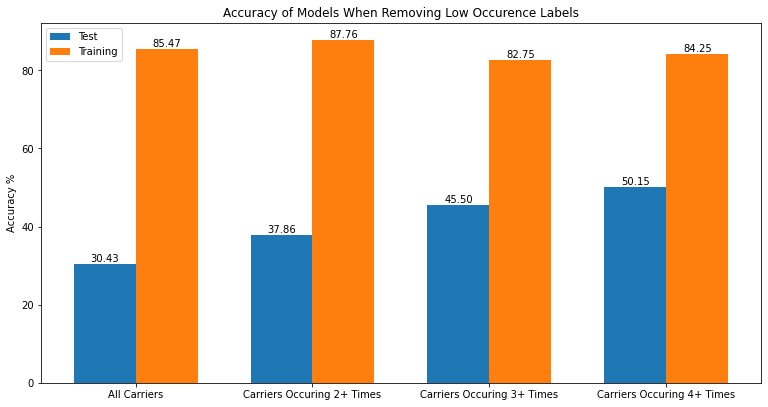

In [170]:
models = ['All Carriers', 'Carriers Occuring 2+ Times', 'Carriers Occuring 3+ Times', 'Carriers Occuring 4+ Times']

# Obtain accuracies of each model
train_accuracies = [((dt.score(X_train, y_train))*100), ((dtRemoval1.score(XR1_train, yR1_train))*100),
               ((dtRemoval2.score(XR2_train, yR2_train))*100), ((dtRemoval3.score(XR3_train, yR3_train))*100)]

test_accuracies = [((dt.score(X_test2, y_test2))*100), ((dtRemoval1.score(XR1_test, yR1_test))*100),
              ((dtRemoval2.score(XR2_test, yR2_test))*100), ((dtRemoval3.score(XR3_test, yR3_test))*100)]


x = np.arange(len(models)).astype('float64')  # the label locations
width = 0.35  # the width of the bars

# Plot performances as bar graph
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1])

rects1 = ax.bar(x - width/2, test_accuracies, width, label='Test')
rects2 = ax.bar(x + width/2, train_accuracies, width, label='Training')
ax.set_xticks(x)
ax.set_xticklabels(models)

ax.bar_label(rects1, fmt='%.2f')
ax.bar_label(rects2, fmt='%.2f')
plt.title("Accuracy of Models When Removing Low Occurence Labels")
plt.ylabel("Accuracy %")
plt.legend()
plt.show()

### 4.4.2 Bar Graph with Custom Top 5 Scoring Performance

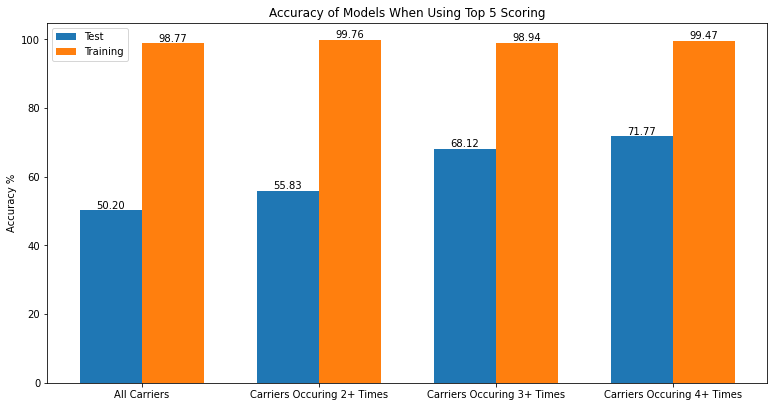

In [171]:
# Now Testing using Top 5 Scoring Function

# Create graph labels
models = ['All Carriers', 'Carriers Occuring 2+ Times', 'Carriers Occuring 3+ Times', 'Carriers Occuring 4+ Times']

# Obtain accuracies
train_accuracies = [(score_top5(X_train, y_train, dt)*100), (score_top5(XR1_train, yR1_train, dtRemoval1)*100),
               (score_top5(XR2_train, yR2_train, dtRemoval2)*100), (score_top5(XR3_train, yR3_train, dtRemoval3)*100)]

test_accuracies = [float(score_top5(X_test2, y_test2, dt)*100), float(score_top5(XR1_test, yR1_test, dtRemoval1)*100),
              float(score_top5(XR2_test, yR2_test, dtRemoval2)*100), float(score_top5(XR3_test, yR3_test, dtRemoval3)*100)]

# Plot accuracies
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1])

rects1 = ax.bar(x - width/2, test_accuracies, width, label='Test')
rects2 = ax.bar(x + width/2, train_accuracies, width, label='Training')
ax.set_xticks(x)
ax.set_xticklabels(models)

ax.bar_label(rects1, fmt='%.2f')
ax.bar_label(rects2, fmt='%.2f')
plt.title("Accuracy of Models When Using Top 5 Scoring")
plt.ylabel("Accuracy %")
plt.legend()
plt.show()